# Lesson 9: Segmentation

In this lesson, among other computer vision tasks, you are going to perform segmentation and something called visual prompting. By that, you would simply specify a point in the picture and the segmentation model will then identify a segmented object of interest.

- In the classroom, the libraries are already installed for you.
- If you would like to run this code on your own machine, you can install the following:

```
    !pip install transformers
    !pip install gradio
    !pip install timm
    !pip install torchvision
```

- Here is some code that suppresses warning messages.

In [1]:
from transformers.utils import logging
logging.set_verbosity_error()

## What is Segmentation?
Image segmentation: The model predicts pixel-wise labels for each pixel of the image with the corresponding label of the pixel.

Segmentation mask generation: The difference is that users can perform visual prompting by guiding the model on the location of the object of interest in order to predict the segmentation mask of the object.

Segment Anything Model (SAM) from Facebook expects an input 2D points, or bounding boxes. The model will predict segmentation mask of that object of interest. In contrary to classic image segmentation, the. predicted mask won't have any label. The only label that you can extract from that mask is that object corresponds to the object of interest that you have specifically selected.

There is also 1 thing you could do with segment anything is the automatic mask generation pipeline. So by that we simply sample some points from the 2D image and try out different combinations of 2D points together because you can also prompt multiple points per mask and filter out the predicted output with the highest scores to get the most relevant segmentation masks in the whole image. If you pass that image and use the automatic mask generation pipeline, you will end up with results such as this one below where you will have the masks for each object of interest.


### Mask Generation with SAM

The [Segment Anything Model (SAM)](https://segment-anything.com) model was released by Meta AI.

In this lab, we are going to use a distilled compressed version of the model called SlimSAM, which basically does the same thing as SAM with similar performances, but it is much smaller. So we will be able to run a segment anything model without the need of having a high compute requirement. 

In [2]:
from PIL import Image

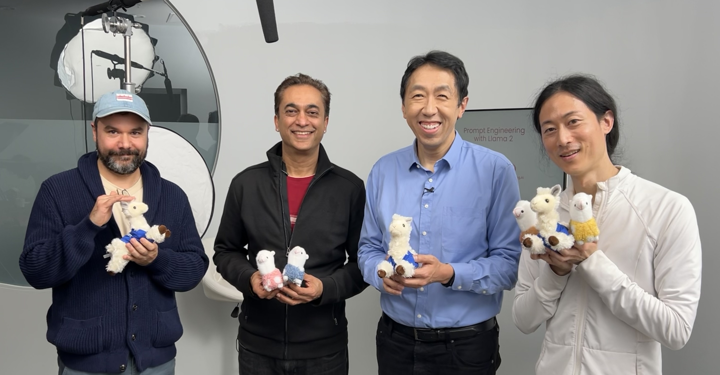

In [3]:
raw_image = Image.open('meta_llamas.jpg')
raw_image.resize((720, 375))

In [4]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

#import pipeline libraries
from transformers import pipeline

# load pipeline
sam_pipe = pipeline("mask-generation",
    "Zigeng/SlimSAM-uniform-77",
                   device="cpu")

Info about [Zigeng/SlimSAM-uniform-77](https://huggingface.co/Zigeng/SlimSAM-uniform-77)

- Running this will take some time
- The higher the value of 'points_per_batch', the more efficient pipeline inference will be

In [5]:
# Run code
output = sam_pipe(raw_image, points_per_batch=32)

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3),
                                np.array([0.6])],
                               axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_pipe_masks_on_image(raw_image, outputs):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  for mask in outputs["masks"]:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()

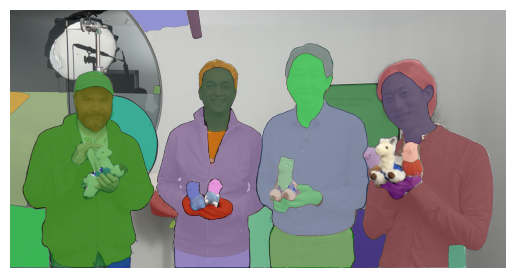

In [11]:
show_pipe_masks_on_image(raw_image, output)

_Note:_ The colors of segmentation, that you will get when running this code, might be different than the ones you see in the video.

The problem with this pipeline is that you need to iterate over all the points and post-process the generated masks, which might be a bit slow for some use cases and applications.

We are going to focus on 1 specific use case where we were going to infer the model with an image and a single point

### Faster Inference: Infer an Image and a Single Point

In [12]:
# Instead of using pipeline, we are going to import the model class itself
from transformers import SamModel, SamProcessor

In [13]:
model = SamModel.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

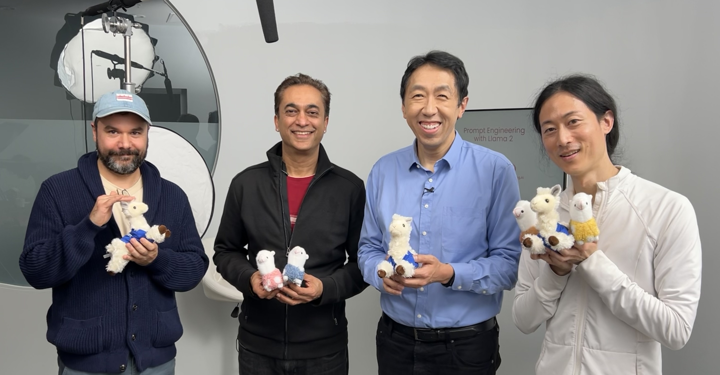

In [14]:
raw_image.resize((720, 375))

- Segment the blue shirt Andrew is wearing.
- Give any single 2D point that would be in that region (blue shirt).

In [15]:
input_points = [[[1600, 700]]]

- Create the input using the image and the single point.
- `return_tensors="pt"` means to return PyTorch Tensors.

In [17]:
inputs = processor(raw_image,
                 input_points=input_points,
                 return_tensors="pt") #Pytorch

- Given the inputs, get the output from the model.

In [18]:
import torch

In [19]:
# Perform a simple inference on the model, so that we make sure we don't compute the gradient.
with torch.no_grad():
    outputs = model(**inputs)

In [21]:
# Post-process the predicted masks in order to resize them to the size of original image
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)

 Length of `predicted_masks` corresponds to the number of images that are used in the input.

In [22]:
len(predicted_masks)

1

- Inspect the size of the first ([0]) predicted mask

In [23]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

torch.Size([1, 3, 1500, 2880])

1 image to be predicted, batch size = 3, size of image = 1500 * 2880

Why 3 batches?\
Can see from overview of SAM architecture, the model predicts 3 segmentation masks together with their confidence scores.

In [24]:
outputs.iou_scores

tensor([[[0.9583, 0.9551, 0.9580]]])

In [25]:
def show_mask_on_image(raw_image, mask, return_image=False):
    if not isinstance(mask, torch.Tensor):
      mask = torch.Tensor(mask)

    if len(mask.shape) == 4:
      mask = mask.squeeze()

    fig, axes = plt.subplots(1, 1, figsize=(15, 15))

    mask = mask.cpu().detach()
    axes.imshow(np.array(raw_image))
    show_mask(mask, axes)
    axes.axis("off")
    plt.show()

    if return_image:
      fig = plt.gcf()
      return fig2img(fig)

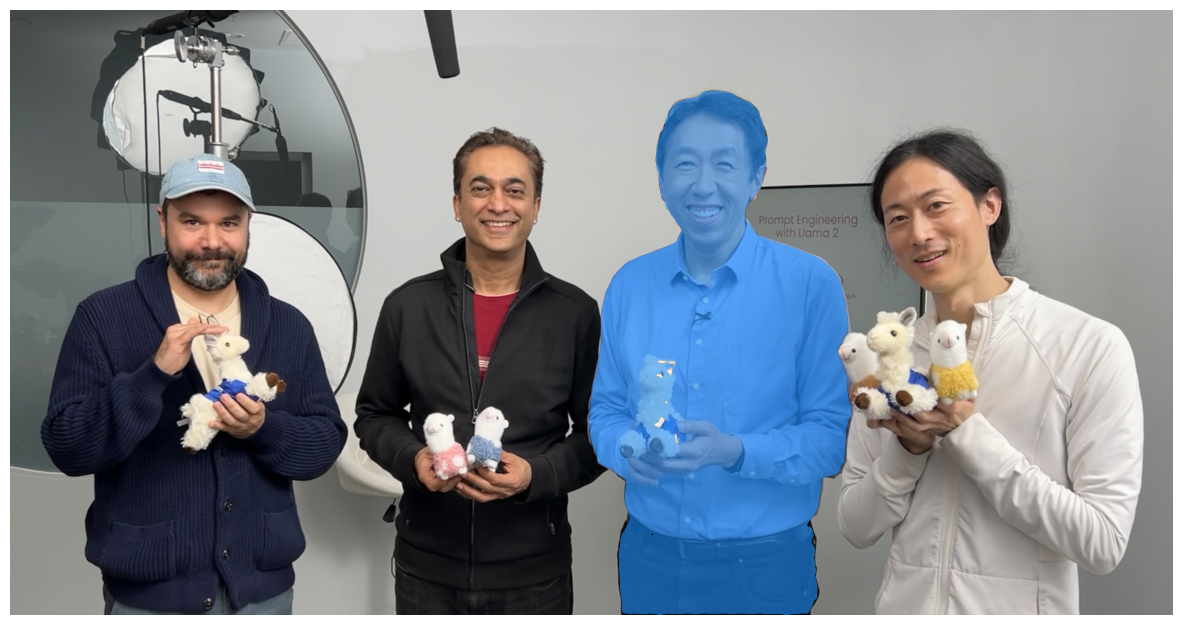

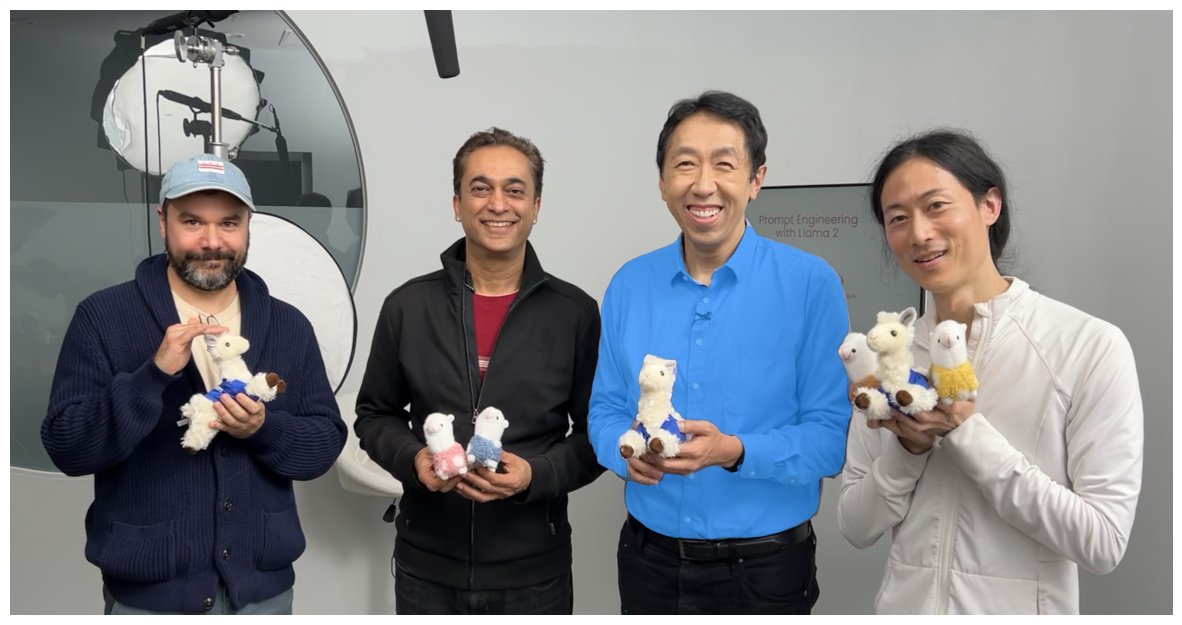

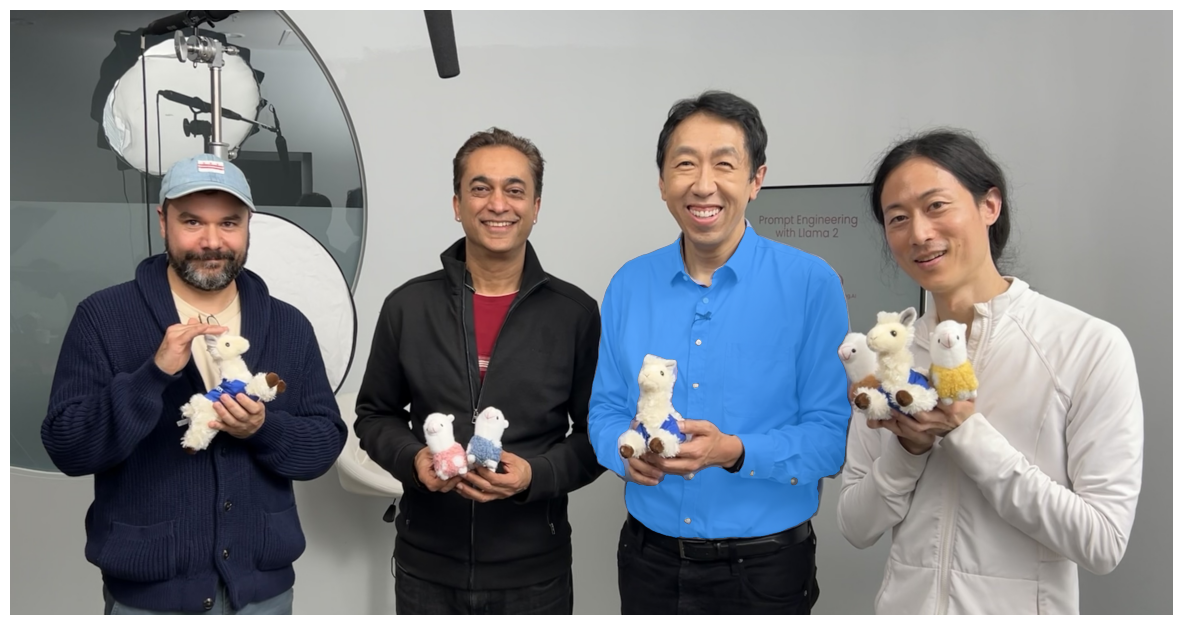

In [26]:
for i in range(3):
    show_mask_on_image(raw_image, predicted_mask[:, i])

## Depth Estimation with DPT

- This model was introduced in the paper [Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413) by Ranftl et al. (2021) and first released in [isl-org/DPT](https://github.com/isl-org/DPT).

DPT (Dense Prediction Transformer)\
DPT is a model that you can use to perform depth estimation given an image.\
Depth estimation is a common task in computer vision, that is also use in autonomous driving.\
For demo, we are going to use a model called DPT Hybrid Midas from Intel.

In [27]:
depth_estimator = pipeline(task="depth-estimation",
                        model="Intel/dpt-hybrid-midas")

config.json:   0%|          | 0.00/9.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/490M [00:00<?, ?B/s]

Info about ['Intel/dpt-hybrid-midas'](https://huggingface.co/Intel/dpt-hybrid-midas)

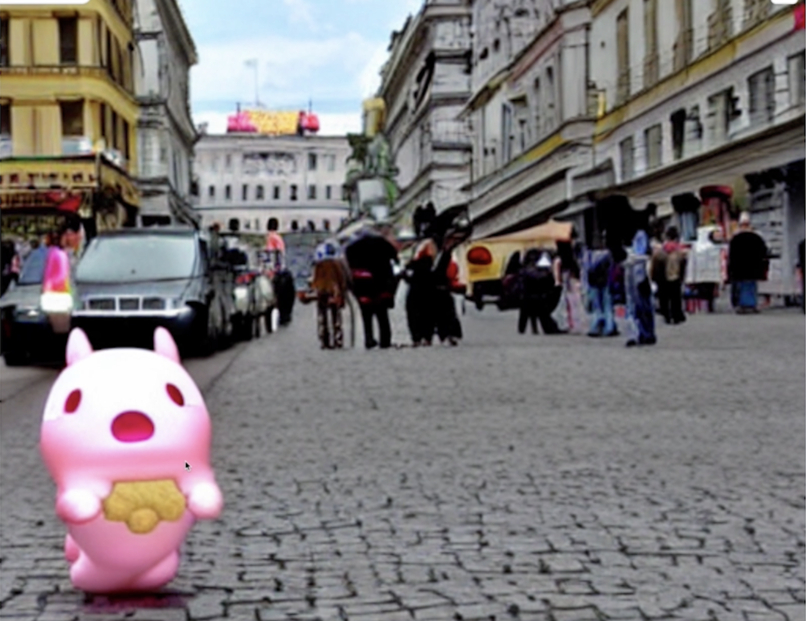

In [34]:
# Inspect the image that we are going to use for this demo
raw_image = Image.open('gradio_tamagochi_vienna.png')
raw_image.resize((806, 621))

- If you'd like to generate this image or something like it, check out the short course on [Gradio](https://www.deeplearning.ai/short-courses/building-generative-ai-applications-with-gradio/) and go to the lesson "Image Generation App".

In [35]:
output = depth_estimator(raw_image)

In [36]:
output

{'predicted_depth': tensor([[ 248.1577,  248.2614,  248.7576,  ...,  468.0616,  447.0024,
           442.8541],
         [ 248.0309,  248.1445,  248.6918,  ...,  477.7603,  458.3918,
           454.5757],
         [ 247.0836,  247.2387,  247.9993,  ...,  508.8521,  494.9487,
           492.2068],
         ...,
         [3040.0325, 3040.3923, 3042.2263,  ..., 3285.1125, 3283.1304,
          3282.7410],
         [3037.8643, 3038.3806, 3041.0225,  ..., 3288.0479, 3286.3186,
          3285.9741],
         [3037.5449, 3038.1074, 3040.9890,  ..., 3289.0525, 3287.3730,
          3287.0371]]),
 'depth': <PIL.Image.Image image mode=L size=1612x1242>}

- Post-process the output image to resize it to the size of the original image.

In [39]:
output["predicted_depth"].shape

torch.Size([1242, 1612])

In [40]:
output["predicted_depth"].unsqueeze(1).shape

torch.Size([1242, 1, 1612])

In [41]:
depth = output["predicted_depth"]
# Now shape is [1242, 1612] (H, W) or something similar.

depth = depth.unsqueeze(0).unsqueeze(0)
# Now shape is [1, 1, 1242, 1612] => (N, C, H, W)

In [43]:
print(depth.shape)

torch.Size([1, 1, 1242, 1612])


In [44]:
prediction = torch.nn.functional.interpolate(
    depth,
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False
)

In [45]:
prediction.shape

torch.Size([1, 1, 1242, 1612])

In [46]:
raw_image.size[::-1],

((1242, 1612),)

In [47]:
prediction

tensor([[[[ 248.1577,  248.2614,  248.7576,  ...,  468.0616,  447.0024,
            442.8541],
          [ 248.0309,  248.1445,  248.6918,  ...,  477.7603,  458.3918,
            454.5757],
          [ 247.0836,  247.2387,  247.9993,  ...,  508.8521,  494.9487,
            492.2068],
          ...,
          [3040.0325, 3040.3923, 3042.2263,  ..., 3285.1125, 3283.1304,
           3282.7410],
          [3037.8643, 3038.3806, 3041.0225,  ..., 3288.0479, 3286.3186,
           3285.9741],
          [3037.5449, 3038.1074, 3040.9890,  ..., 3289.0525, 3287.3730,
           3287.0371]]]])

- Normalize the predicted tensors (between 0 and 255) so that they can be displayed.

In [48]:
import numpy as np 

In [49]:
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

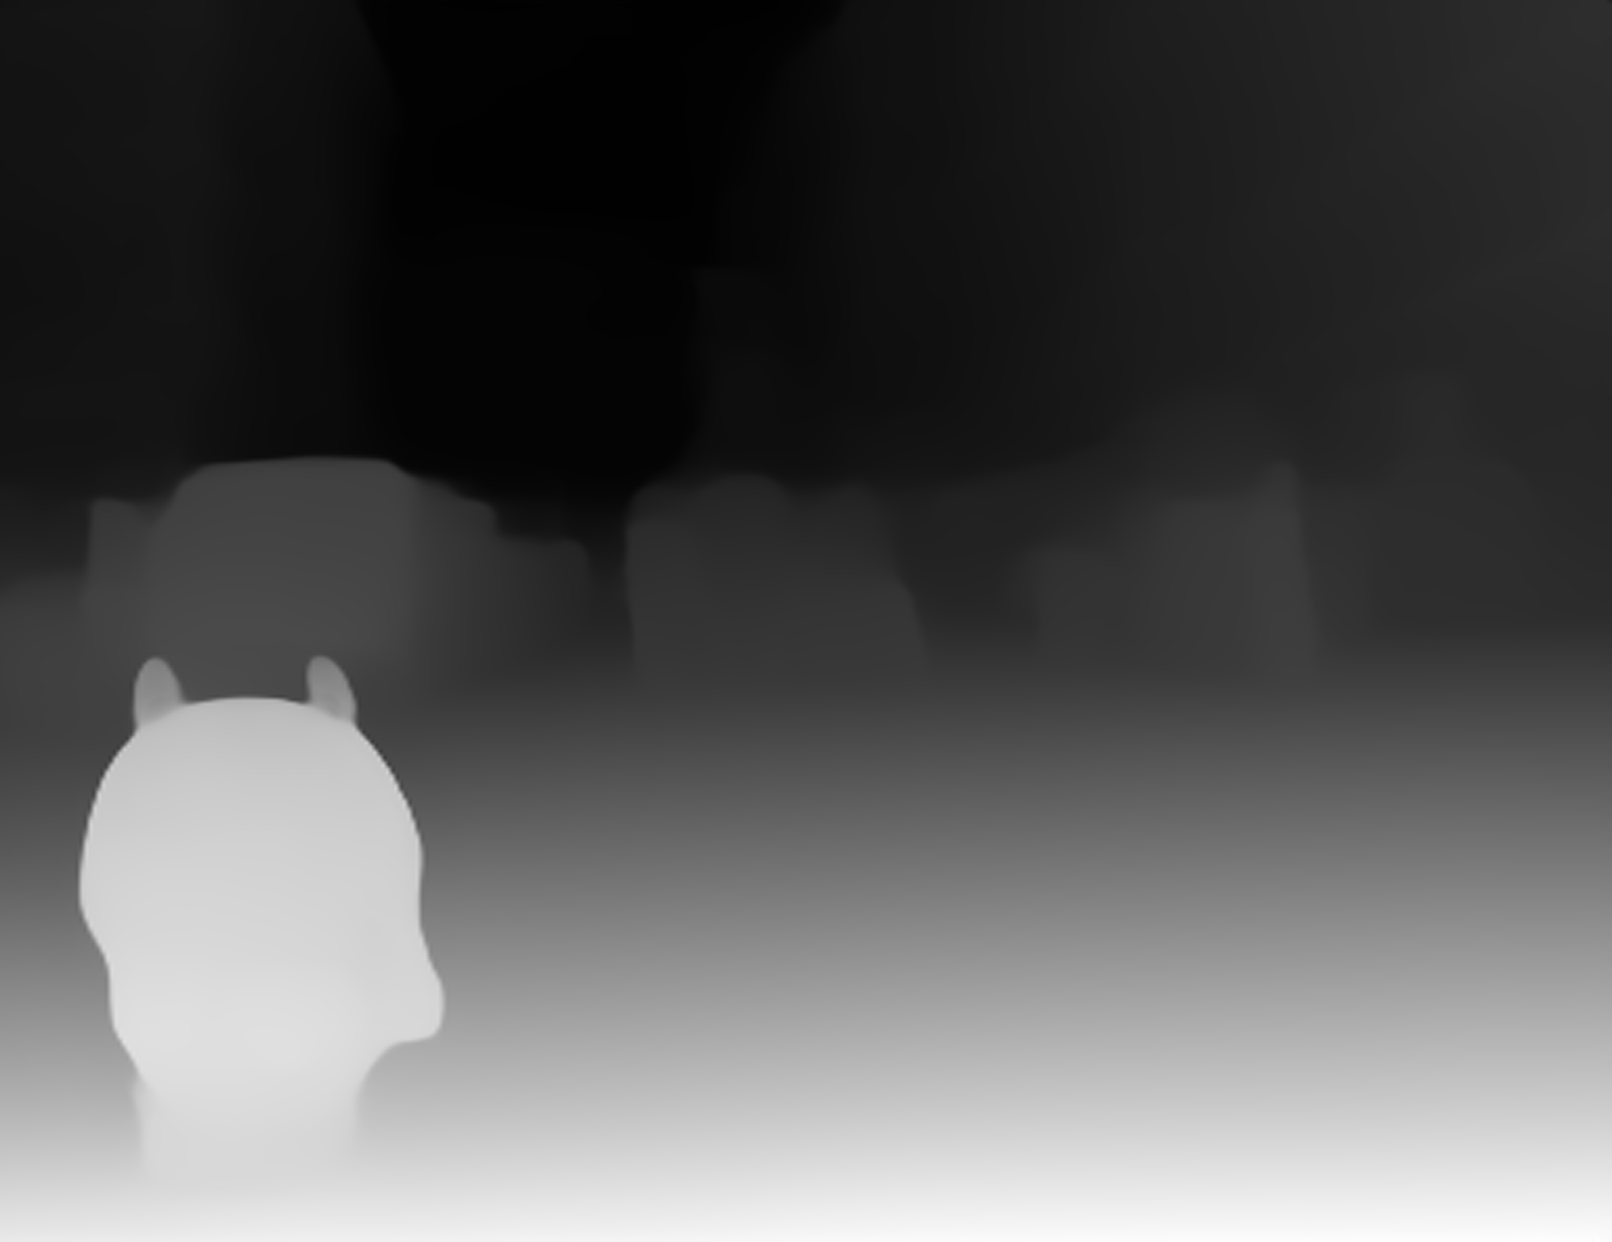

In [50]:
depth

### Demo using Gradio

### Troubleshooting Tip
- Note, in the classroom, you may see the code for creating the Gradio app run indefinitely.
  - This is specific to this classroom environment when it's serving many learners at once, and you won't wouldn't experience this issue if you run this code on your own machine.
- To fix this, please restart the kernel (Menu Kernel->Restart Kernel) and re-run the code in the lab from the beginning of the lesson.

In [51]:
import os
import gradio as gr
from transformers import pipeline

In [64]:
def launch(input_image):
    out = depth_estimator(input_image)

    # resize the prediction
    prediction = torch.nn.functional.interpolate(
        out["predicted_depth"].unsqueeze(0).unsqueeze(0),
        size=input_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # normalize the prediction
    output = prediction.squeeze().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

In [65]:
iface = gr.Interface(launch, 
                     inputs=gr.Image(type='pil'), 
                     outputs=gr.Image(type='pil'))

In [66]:
iface.launch(share=True) #, server_port=int(os.environ['PORT1'])

* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://676e45359d0d56d8ad.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [67]:
iface.close()

Closing server running on port: 7862


### Close the app
- Remember to call `.close()` on the Gradio app when you're done using it.

### Try it yourself! 
- Try this model with your own images!